In [12]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt
from PIL import Image
# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# K-means for image compression and segmentation

The goal of image compression is to take an image and encode it in a way such that the number of bits of the encoded version is smaller than that of the original. There are two options to go about this, namely lossless and lossy compression. In lossless compression we require that if we encode and then decode the image we retrieve the exact original. Lossy compression lifts this constraint by allowing the decoded image to differ from the original, thereby generally allowing further compression $-$ at the cost of quality loss. K-means offers a method for lossy compression, which works as follows:

1. Consider an image of $N$ pixels to be itself a dataset. The datapoints are then pixels in a $3$D space of (R, G, B) intensities (or $1$D for a grayscale image).

2. Perform K-means on this single-image dataset of pixels to get cluster centers $\boldsymbol{\mu}_k$ and memberships. Remember the cluster centers $\boldsymbol{\mu}_k$ are points in (R, G, B) space (or intensity space for grayscale).

3. Store memberships and the cluster centers. These make up the encoded image.

4. To decode the image, set the colour of each pixel to be the cluster center $\boldsymbol{\mu}_k$ to which this particular pixel belongs.

What is the size reduction of this method? An uncompressed colour image of $N$ pixels requires $24N$ bits ($8$ bits for each colour channel). The K-means encoding of this image involves the class membership of each pixel, which requires $N$log$_2K$ bits (log$_2K$ bits for each pixel) plus the cluster centers, which require $24K$ bits ($24$ bits for each cluster in RGB form). The total number of bits in the compressed image is therefore $24K + \text{log}_2K$ as opposed to $24N$. A colour image with $N = 1920 \times 1080 = 2073600$ pixels requires $49766400$ bits. Using K-means with $K = 2, 5, 20$ it can be compressed down to $2073648$, $4814870$ and $8962430$ bits respectively, with corresponding compression ratios of $4.16\%$, $9.67\%$ and $18.0\%$

We'll now apply this compression scheme to a grayscale and a colour image to see what the decompressed images look like, starting by showing the originals

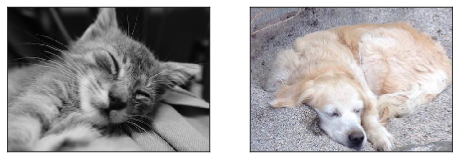

In [13]:
plt.figure(figsize = (8, 8))
plt.subplot(121)
cat = plt.imread('sleepy_cat.jpg')
plt.imshow(cat, origin = 'upper')
remove_axes()

plt.subplot(122)
dog = plt.imread('sleepy_dog.jpg')
plt.imshow(dog, origin = 'upper')
remove_axes()
plt.show()

For convenience, we will also write an implementation of k-means in a function, which performs the whole optimisation process. Cluster memberships are initialised randomly within function and the initial cluster centers are chosen manually and passed to the function by the user.

In [14]:
def k_means(x, K, max_steps, mu_init):
    
    N, D = x.shape # N: number of datapoints, D: number of input dimensions
    mu = mu_init.copy() # copy cluster centers to avoid mutation

    s = np.zeros(shape = (N, K)) # set all membership indices to 0
    memberships = np.random.choice(np.arange(0, K), N) # randomly choose a cluster for each point
    s[np.arange(s.shape[0]), memberships] = 1 # set the 1-entries according to the random sample
    
    x_stacked = np.stack([x]*K, axis = 1) # stack K copies of x to do calculation for each cluster
    losses = [np.sum(s*np.sum((x_stacked - mu)**2, axis = 2))] # array to store costs, containing 1st cost
    converged = False
    
    for i in range(max_steps):

        mus = (s.T).dot(x) # compute K centers in one go
        N_k = s.sum(axis = 0).reshape((-1, 1)) # number of members of cluster k
        mus[np.where(N_k >= 1)[0], :] /= N_k[np.where(N_k >= 1)[0]] # distance of each point from each cluster mean

        distances = np.sum((x_stacked - mus)**2, axis = 2) # find which cluster mean is closest to each point
        min_idx = np.argmin(distances, axis = 1)
        s_prev = s.copy()
        s = np.zeros_like(s)
        s[np.arange(s.shape[0]), min_idx] = 1

        losses.append(np.sum(s*np.sum((x_stacked - mus)**2, axis = 2)))
        
        if np.prod(np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1)):
            break
            
    return s, mus, losses

Using ```k_means``` we can easily perform the optimisation process and obtain the cluster memberships ```s``` and centers ```mus```. To obtain the decoded image we loop over $K$, and set the colour of every pixel of a given cluster to be the center of that cluster ```mu_dog[k]``` (or ```mu_cat[k]```).

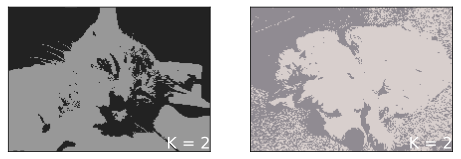

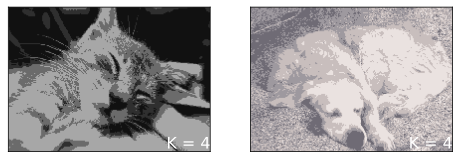

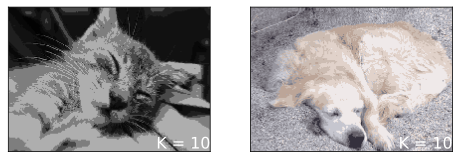

In [15]:
flat_dog, flat_cat = dog.reshape((-1, 3)), cat.reshape((-1, 1))

for K in [2, 4, 10]:
    s_dog, mu_dog, losses_dog = k_means(flat_dog, K, 10, np.random.rand(K, 1)*256)
    s_cat, mu_cat, losses_cat = k_means(flat_cat, K, 10, np.random.rand(K, 1)*256)
    
    K_colored_dog = flat_dog.copy()
    K_colored_cat = flat_cat.copy()
    
    for k in range(K):
        K_colored_dog[np.where(np.argmax(s_dog, axis = -1) == k)[0], :] = mu_dog[k]
        K_colored_cat[np.where(np.argmax(s_cat, axis = -1) == k)[0], :] = mu_cat[k]

    K_colored_dog = K_colored_dog.reshape(dog.shape)
    K_colored_cat = K_colored_cat.reshape(cat.shape)
    
    plt.figure(figsize = (8, 8))
    plt.subplot(121)
    plt.imshow(K_colored_cat, origin = 'upper')
    plt.text(450, 322, s = 'K = {}'.format(K), color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

    plt.subplot(122)
    plt.imshow(K_colored_dog, origin = 'upper')
    plt.text(450, 322, s = 'K = {}'.format(K), color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()
    
    plt.show()

As more colours are added, the level of detail in the image progressively resembles the original. Note also how increasing $K$ increases the number of distinct colours in the dog picture and the number of different shades in the cat picture. It is also worthwhile to stress that pixels are clustered according to their distance in intensity space and not according to their proximity in the picture itself. Nearby pixels often have correlated colours when they belong to the same object however so k-means will cluster them together preserving the rough shape of the object, although clustering is carried out strictly in intensity space.

The colour correlation between different pixels points to another application of k-means, namely image segmentation. Here the objective is to divide the image in different regions which belong to the same object. K-means can achieve this by grouping pixels of similar colours together, presuming that pixels belonging to a certain object will have similar colours which will be clustered together. In the example below we apply this k-means to some Google Street View images of Cambridge.

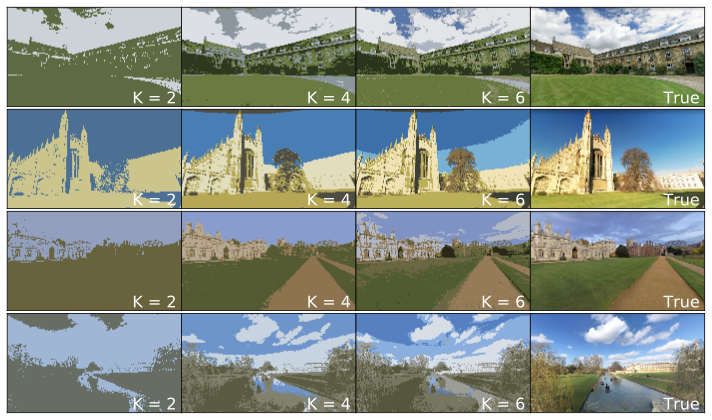

In [16]:
plt.figure(figsize = (10, 6))
for i in range(4):
    
    picture = plt.imread('{}.png'.format(str(i).zfill(3)))
    flat_pic = picture.reshape((-1, 3))
    
    for j, K in enumerate([2, 4, 6]):
        plt.subplot(4, 4, 4*i + j + 1)

        s_pic, mu_pic, losses_pic = k_means(flat_pic, K, 10, np.random.rand(K, 1)*256)
        pic_colors = [np.mean(flat_pic[np.where(np.argmax(s_pic, axis = -1) == k)], axis = 0) for k in np.arange(K)]
        K_colored_pic = flat_pic.copy()

        for k in range(K):
            K_colored_pic[np.where(np.argmax(s_pic, axis = -1) == k)[0], :] = pic_colors[k]

        K_colored_pic = K_colored_pic.reshape(picture.shape)
        plt.imshow(K_colored_pic, origin = 'upper')
        plt.text(720, 410, s = 'K = {} '.format(K), color = 'white', fontsize = 16,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
        remove_axes()

    plt.subplot(4, 4, 4*(i+1))
    plt.imshow(picture, origin = 'upper')
    plt.text(720, 410, s = 'True ', color = 'white', fontsize = 16,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

plt.tight_layout(w_pad = 0, h_pad = 0)
plt.show()

The image could then be partitioned into areas different colours. Clearly this method will perform quite poorly in situations where a single object contains multiple and/or different colours. In such cases, the average colours (cluster centers) may be poor representations of the multiple colours appearing in the images if the value of $K$ is small, or the depicted object may be falsely partitioned in several different patches if $K$ is larger.

<img src="clust_kmeans_fail_ex.svg" alt="Snow" style="width:100%; float: center; padding:0px">

K-means may perform quite poorly and is not a reliable image segmentation method by itself. It may howevery be used as a preprocessing stage before applying a more complicated segmentation model to the image.